In [1]:
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import MetadataCatalog, DatasetCatalog
import detectron2.data.transforms as T
from detectron2.structures.image_list import ImageList
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.modeling.box_regression import Box2BoxTransform
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetMapper
from detectron2.data import (
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.data.samplers import TrainingSampler
from detectron2.modeling.proposal_generator.proposal_utils import add_ground_truth_to_proposals
from detectron2.modeling.sampling import subsample_labels
from detectron2.structures import Boxes, Instances, pairwise_iou
from detectron2.modeling.matcher import Matcher

from fsdet.modeling.roi_heads.fast_rcnn import FastRCNNOutputs

import cv2
import torch, torchvision
import logging

from sklearn import svm
from joblib import dump, load
from detectron2.layers import nonzero_tuple
import numpy as np

logging.basicConfig(level=logging.INFO)

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



# Register my_dataset

In [2]:
# train = True
train = False
if train == True:
    json_dir = 'datasets/coco_experiments/seed1/full_box_30shot_person_trainval.json'
    image_dir = 'datasets/coco/trainval2014'
    register_coco_instances("my_dataset", {}, json_dir, image_dir)
    # MetadataCatalog.get("my_dataset").thing_classes = ["person"] # json file itself has all the category metadata
else:
    json_dir = 'datasets/coco_experiments/seed1/full_box_1000shot_person_test.json'
    image_dir = 'datasets/coco/trainval2014'
    register_coco_instances("my_dataset", {}, json_dir, image_dir)
    clf = load('svm_results/svm_model_finetuned_prop_base.joblib') 

# Build model using cfg file

In [3]:
cfg = get_cfg()
cfg.merge_from_file('configs/COCO-detection/faster_rcnn_R_101_FPN_base.yaml')
model = build_model(cfg)  # returns a torch.nn.Module

model.eval()
metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])

ckpt_file = 'checkpoints/coco/base_model/model_final.pth'
# ckpt_file = 'checkpoints/coco/faster_rcnn/30shot_person_unfreeze_lastfews/model_final.pth'
# ckpt_file = 'checkpoints/coco/faster_rcnn/30shot_person_unfreeze_whole/model_0015999.pth'
DetectionCheckpointer(model).load(ckpt_file)

INFO:fvcore.common.checkpoint:Loading checkpoint from checkpoints/coco/base_model/model_final.pth


{'optimizer': {'state': {140508395095672: {'momentum_buffer': tensor([[[[-1.2293e-04]],
    
             [[-3.7314e-04]],
    
             [[-3.6808e-04]],
    
             ...,
    
             [[-2.4900e-04]],
    
             [[-1.9884e-04]],
    
             [[ 3.8510e-05]]],
    
    
            [[[ 2.9357e-04]],
    
             [[ 1.2172e-03]],
    
             [[ 1.1192e-03]],
    
             ...,
    
             [[ 8.4696e-04]],
    
             [[ 1.7627e-03]],
    
             [[ 1.2127e-03]]],
    
    
            [[[-1.2993e-04]],
    
             [[ 3.6365e-04]],
    
             [[ 1.1718e-04]],
    
             ...,
    
             [[ 1.7940e-04]],
    
             [[ 3.9368e-04]],
    
             [[-1.0029e-04]]],
    
    
            ...,
    
    
            [[[-3.4145e-04]],
    
             [[-3.4512e-04]],
    
             [[-1.2064e-04]],
    
             ...,
    
             [[-1.1182e-04]],
    
             [[-1.0942e-03]],
    


In [4]:
if train:
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 20
    cfg.MODEL.ROI_HEADS.POSITIVE_FRACTION = 0.8
else:
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
    cfg.MODEL.ROI_HEADS.POSITIVE_FRACTION = 0.50
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
def _sample_proposals(matched_idxs, matched_labels, gt_classes):
    """
    Based on the matching between N proposals and M groundtruth,
    sample the proposals and set their classification labels.
    Args:
        matched_idxs (Tensor): a vector of length N, each is the best-matched
            gt index in [0, M) for each proposal.
        matched_labels (Tensor): a vector of length N, the matcher's label
            (one of cfg.MODEL.ROI_HEADS.IOU_LABELS) for each proposal.
        gt_classes (Tensor): a vector of length M.
    Returns:
        Tensor: a vector of indices of sampled proposals. Each is in [0, N).
        Tensor: a vector of the same length, the classification label for
            each sampled proposal. Each sample is labeled as either a category in
            [0, num_classes) or the background (num_classes).
    """
    has_gt = gt_classes.numel() > 0
    # Get the corresponding GT for each proposal
    if has_gt:
        gt_classes = gt_classes[matched_idxs]
        # Label unmatched proposals (0 label from matcher) as background (label=num_classes)
        gt_classes[matched_labels == 0] = cfg.MODEL.ROI_HEADS.NUM_CLASSES
        # Label ignore proposals (-1 label)
        gt_classes[matched_labels == -1] = -1
    else:
        gt_classes = torch.zeros_like(matched_idxs) + cfg.MODEL.ROI_HEADS.NUM_CLASSES

    sampled_fg_idxs, sampled_bg_idxs = subsample_labels(
        gt_classes,
        cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE,
        cfg.MODEL.ROI_HEADS.POSITIVE_FRACTION,
        cfg.MODEL.ROI_HEADS.NUM_CLASSES,
    )

    sampled_idxs = torch.cat([sampled_fg_idxs, sampled_bg_idxs], dim=0)
    return sampled_idxs, gt_classes[sampled_idxs]

def label_and_sample_proposals(proposals, targets):
    proposal_matcher = Matcher(
        cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS,
        cfg.MODEL.ROI_HEADS.IOU_LABELS,
        allow_low_quality_matches=False,
    )

    gt_boxes = [x.gt_boxes for x in targets]
    proposals_with_gt = []
    num_fg_samples = []
    num_bg_samples = []
    sampled_ft_vecs_list = []

    proposal_append_gt = False
    if proposal_append_gt:
        proposals = add_ground_truth_to_proposals(gt_boxes, proposals)


    for i, (proposals_per_image, targets_per_image) in enumerate(zip(proposals, targets)):
#         feature_vectors =box_features[i*1000:(i+1)*1000, :]
        has_gt = len(targets_per_image) > 0
        match_quality_matrix = pairwise_iou(
            targets_per_image.gt_boxes, proposals_per_image.proposal_boxes
        )
        matched_idxs, matched_labels = proposal_matcher(match_quality_matrix)
        sampled_idxs, gt_classes = _sample_proposals(
            matched_idxs, matched_labels, targets_per_image.gt_classes
        )

        # Set target attributes of the sampled proposals:
#         feature_vectors = feature_vectors[sampled_idxs]
        proposals_per_image = proposals_per_image[sampled_idxs]
        proposals_per_image.gt_classes = gt_classes

        # We index all the attributes of targets that start with "gt_"
        # and have not been added to proposals yet (="gt_classes").
        if has_gt:
            sampled_targets = matched_idxs[sampled_idxs]
            # NOTE: here the indexing waste some compute, because heads
            # will filter the proposals again (by foreground/background,
            # etc), so we essentially index the data twice.
            for (
                trg_name,
                trg_value,
            ) in targets_per_image.get_fields().items():
                if trg_name.startswith(
                    "gt_"
                ) and not proposals_per_image.has(trg_name):
                    proposals_per_image.set(
                        trg_name, trg_value[sampled_targets]
                    )
        else:
            gt_boxes = Boxes(
                targets_per_image.gt_boxes.tensor.new_zeros(
                    (len(sampled_idxs), 4)
                )
            )
            proposals_per_image.gt_boxes = gt_boxes

        num_bg_samples.append(
            (gt_classes == cfg.MODEL.ROI_HEADS.NUM_CLASSES).sum().item()
        )
        num_fg_samples.append(gt_classes.numel() - num_bg_samples[-1])
#         sampled_ft_vecs_list.append(feature_vectors)
        proposals_with_gt.append(proposals_per_image)
    return proposals_with_gt
#     return proposals_with_gt, sampled_ft_vecs_list

In [5]:
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('coco_test_base',)
  TRAIN: ('coco_trainval_base',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: ['res

# Load data from dataset

In [6]:
data_list = DatasetCatalog.get("my_dataset")
print(len(data_list))
print(data_list[0])

INFO:detectron2.data.datasets.coco:Loaded 239 images in COCO format from datasets/coco_experiments/seed1/full_box_1000shot_person_test.json


239
{'file_name': 'datasets/coco/trainval2014/COCO_val2014_000000000764.jpg', 'height': 343, 'width': 500, 'image_id': 764, 'annotations': [{'iscrowd': 0, 'bbox': [70.14, 95.58, 78.62, 185.76], 'category_id': 0, 'segmentation': [[70.91, 269.0, 77.85, 276.71, 86.33, 281.34, 97.89, 280.57, 97.89, 275.17, 91.72, 268.23, 94.04, 261.3, 107.91, 220.44, 112.53, 209.65, 115.62, 206.57, 125.64, 218.13, 127.18, 219.67, 127.18, 222.76, 118.7, 241.26, 111.76, 250.51, 110.99, 256.67, 116.39, 258.21, 117.93, 261.3, 123.33, 265.92, 131.8, 274.4, 131.03, 266.69, 134.89, 257.44, 141.05, 248.96, 148.76, 215.05, 129.49, 180.36, 132.58, 161.87, 133.35, 149.53, 129.49, 141.82, 129.49, 139.51, 137.97, 130.26, 135.66, 124.1, 127.95, 120.24, 120.24, 121.01, 111.76, 129.49, 107.91, 128.72, 107.91, 124.1, 106.37, 117.16, 107.91, 107.14, 105.6, 102.51, 102.51, 97.89, 93.27, 95.58, 86.33, 98.66, 82.47, 105.6, 80.93, 110.22, 80.93, 119.47, 84.79, 127.18, 87.87, 131.8, 81.7, 139.51, 84.02, 149.53, 86.33, 161.09, 87

In [7]:
transform_gen = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST],
            cfg.INPUT.MAX_SIZE_TEST,
            )
data_loader = build_detection_train_loader(DatasetCatalog.get("my_dataset"),
                                           mapper=DatasetMapper(cfg, is_train=True, augmentations=[transform_gen]),
                                           total_batch_size = 10)
data_loader_it = iter(data_loader)
# data = next(data_loader_it)
# print(len(data))
# print(data[0]['image'].shape)
# # print(data)

INFO:detectron2.data.datasets.coco:Loaded 239 images in COCO format from datasets/coco_experiments/seed1/full_box_1000shot_person_test.json
INFO:detectron2.data.dataset_mapper:[DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=[800, 800], max_size=1333)]
INFO:detectron2.data.common:Serializing 239 elements to byte tensors and concatenating them all ...
INFO:detectron2.data.common:Serialized dataset takes 0.67 MiB


# Forward and Sample together

In [8]:
proposals_with_gt = []
sampled_ft_vecs_list = []
outputs_list = []
iter_num = 3 if train else 10

box2box_transform = Box2BoxTransform(
            weights=cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS
        )
smooth_l1_beta = cfg.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA
test_score_thresh        = cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST
test_nms_thresh          = cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST
test_detections_per_img  = cfg.TEST.DETECTIONS_PER_IMAGE

with torch.no_grad():
    for i in range(iter_num):
        data = next(data_loader_it)
        img_tensors_list = [d['image'].float() for d in data]
        images = ImageList.from_tensors(img_tensors_list, model.backbone.size_divisibility).to('cuda')
        input_images = images.tensor
        print('input_images.shape: ', input_images.shape)
        features = model.backbone(input_images)
        proposals_list, _ = model.proposal_generator(images, features)
        print('proposal num per img:', proposals_list[0].objectness_logits.shape)
        
        proposals = [proposal for proposal in proposals_list]
        targets = [d['instances'].to('cuda') for d in data]
        
        proposals_with_gt_batch = label_and_sample_proposals(proposals, targets)
        proposals_with_gt.extend(proposals_with_gt_batch)
        
#         instances, _ = model.roi_heads(images, features, proposals_list)
#         print('\ninstance for image 0:', instances[0], '\n')

        box_features = model.roi_heads.box_pooler(
            [features[f] for f in ["p2", "p3", "p4", "p5"]], [x.proposal_boxes for x in proposals_with_gt_batch]
        )
        print(box_features.shape)
        box_features = model.roi_heads.box_head(box_features)
        print(box_features.shape)
        
        pred_class_logits, pred_proposal_deltas = model.roi_heads.box_predictor(
            box_features
        )
        print('pred_class_logits', pred_class_logits[:3])
        print('pred_proposal_deltas', pred_proposal_deltas.shape)
        
        
        sampled_ft_vecs_list.extend(box_features)
        
        outputs = FastRCNNOutputs(
            box2box_transform,
            pred_class_logits,
            pred_proposal_deltas,
            proposals_with_gt_batch,
            smooth_l1_beta,
        )
        
        pred_instances, _ = outputs.inference(
                test_score_thresh,
                test_nms_thresh,
                test_detections_per_img,
        )
        print(len(pred_instances))
        print(pred_instances[0])
        
        outputs_list.extend(pred_instances)
        
        X = box_features.to('cpu').detach().numpy()
        y_hat = clf.predict(X)
        pred_class_logits_svm = np.zeros((pred_class_logits.shape))
        for i in range(y_hat.shape[0]):
            pred_class_logits_svm[i][0] = 1 - y_hat[i]
            pred_class_logits_svm[i][-1] = y_hat[i]
        pred_class_logits_svm = torch.from_numpy(pred_class_logits_svm).to('cuda')
        print(y_hat.shape)
        print(pred_class_logits_svm[:3])
        
        outputs_svm = FastRCNNOutputs(
            box2box_transform,
            pred_class_logits_svm,
            pred_proposal_deltas,
            proposals_with_gt_batch,
            smooth_l1_beta,
        )
        
        pred_instances_svm, _ = outputs_svm.inference(
                test_score_thresh,
                test_nms_thresh,
                test_detections_per_img,
        )
        print(len(pred_instances_svm))
        print(pred_instances_svm[0]) 
        

        
        print("end one iter\n\n")
        torch.cuda.empty_cache()
print('\n\n', len(sampled_ft_vecs_list))
print(len(proposals_with_gt))
print(sampled_ft_vecs_list[0].shape)
print(len(outputs_list))
print(outputs_list[0])

input_images.shape:  torch.Size([10, 3, 1216, 800])
proposal num per img: torch.Size([1000])
torch.Size([2560, 256, 7, 7])
torch.Size([2560, 1024])
pred_class_logits tensor([[ 2.1107, -1.6203,  1.5199, -1.8126,  0.0626, -0.2860,  3.5548,  2.5064,
         -1.2821, -0.6374,  4.9815,  2.3810,  3.4564, -0.6495,  1.5427, -0.8016,
         -0.5396, -0.3151,  0.5158,  0.0387, -0.5483,  1.6875, -0.1869,  0.3659,
         -1.1660, -0.7347, -1.9406, -3.0175, -2.6237, -1.5886, -0.7991,  1.9729,
          0.3983,  0.8781, -1.0817, -0.0510, -1.7928, -0.1151, -1.6092,  1.0115,
          0.7322,  0.5389,  0.2810, -1.6783, -1.2815, -0.1847, -3.0053,  0.1651,
         -2.9056, -2.2157, -2.1555, -1.5877, -0.6961, -1.7037, -1.4672, -0.0377,
         -1.7202,  5.1901,  0.3987, -1.4739, 11.4182],
        [ 2.2717, -0.9631,  2.5864, -1.4966,  0.9503, -0.8916,  3.6933,  2.9417,
         -1.2446, -1.0307,  6.1629,  2.2508,  3.3075, -1.6203,  2.3818, -0.7451,
         -1.3807, -1.0304,  1.6131,  0.5499, -1.87

/home/cloudlet/work/few-shot-object-detection/fsdet/modeling/roi_heads/fast_rcnn.py:115: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370116979/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


(2560,)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]], device='cuda:0', dtype=torch.float64)
10
Instances(num_instances=0, image_height=1208, image_width=800, fields=[pred_boxes: Boxes(tensor([], device=

(2560,)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]], device='cuda:0', dtype=torch.float64)
10
Instances(num_instances=0, image_height=800, image_width=1067, fields=[pred_boxes: Boxes(tensor([], device=

(2560,)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]], device='cuda:0', dtype=torch.float64)
10
Instances(num_instances=0, image_height=1000, image_width=800, fields=[pred_boxes: Boxes(tensor([], device=

(2560,)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]], device='cuda:0', dtype=torch.float64)
10
Instances(num_instances=0, image_height=800, image_width=1002, fields=[pred_boxes: Boxes(tensor([], device=

(2560,)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)
10
Instances(num_instances=0, image_height=800, image_width=1196, fields=[pred_boxes: Boxes(tensor([], device=

# Forward the model until box_head and get the feature vectors

In [9]:
# img_tensors_list = [d['image'].float() for d in data]
# # images = ImageList.from_tensors([image, image2]).to('cuda')
# images = ImageList.from_tensors(img_tensors_list, model.backbone.size_divisibility).to('cuda')
# input_images = images.tensor
# print(input_images.shape)

In [10]:
# features = model.backbone(input_images)
# print(features.keys(), '\n')
# # FPN's multiple feature map output

# proposals_list, _ = model.proposal_generator(images, features)
# print(proposals_list[0].proposal_boxes)
# print(proposals_list[0].objectness_logits.shape, '\n')
# # RPN's proposals outputs, including the bboxes of 1000 proposals and their objectness_logits

# # from detectron2.modeling.proposal_generator.proposal_utils import add_ground_truth_to_proposals
# # targets = [d['instances'] for d in data]
# # gt_boxes = [x.gt_boxes.to('cuda') for x in targets]

# # proposal_append_gt = True
# # if proposal_append_gt:
# #     proposals_list = add_ground_truth_to_proposals(gt_boxes, proposals_list)

# instances, _ = model.roi_heads(images, features, proposals_list)
# print(instances[0], '\n')
# # print(instances[1], '\n')
# # The final outputs of the classifier and box regressor, inclduing the pred_boxes, their scores and classes

In [11]:
# box_features = model.roi_heads.box_pooler(
#     [features[f] for f in ["p2", "p3", "p4", "p5"]], [x.proposal_boxes for x in proposals_list]
# )
# box_features = model.roi_heads.box_head(box_features).to('cpu')
# print(box_features.shape)
# # print(box_features[:3, :20])
# # print(box_features[1000:1003, :20])

# Sample proposals X and get their groundtruth label y

In [12]:
# proposals = [proposal.to('cpu') for proposal in proposals_list]
# print(len(proposals), type(proposals[0]))
# # print(proposals[0])
# targets = [d['instances'] for d in data]
# print(len(targets), type(targets[0]))
# print(targets[0])

In [13]:
# proposal_matcher = Matcher(
#             cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS,
#             cfg.MODEL.ROI_HEADS.IOU_LABELS,
#             allow_low_quality_matches=False,
#         )

# gt_boxes = [x.gt_boxes for x in targets]
# proposals_with_gt = []
# num_fg_samples = []
# num_bg_samples = []
# sampled_ft_vecs_list = []

# proposal_append_gt = False
# if proposal_append_gt:
#     proposals = add_ground_truth_to_proposals(gt_boxes, proposals)
    

# for i, (proposals_per_image, targets_per_image) in enumerate(zip(proposals, targets)):
#     feature_vectors =box_features[i*1000:(i+1)*1000, :]
#     has_gt = len(targets_per_image) > 0
#     match_quality_matrix = pairwise_iou(
#         targets_per_image.gt_boxes, proposals_per_image.proposal_boxes
#     )
#     matched_idxs, matched_labels = proposal_matcher(match_quality_matrix)
#     sampled_idxs, gt_classes = _sample_proposals(
#         matched_idxs, matched_labels, targets_per_image.gt_classes
#     )

#     # Set target attributes of the sampled proposals:
#     feature_vectors = feature_vectors[sampled_idxs]
#     proposals_per_image = proposals_per_image[sampled_idxs]
#     proposals_per_image.gt_classes = gt_classes
    
#     # We index all the attributes of targets that start with "gt_"
#     # and have not been added to proposals yet (="gt_classes").
#     if has_gt:
#         sampled_targets = matched_idxs[sampled_idxs]
#         # NOTE: here the indexing waste some compute, because heads
#         # will filter the proposals again (by foreground/background,
#         # etc), so we essentially index the data twice.
#         for (
#             trg_name,
#             trg_value,
#         ) in targets_per_image.get_fields().items():
#             if trg_name.startswith(
#                 "gt_"
#             ) and not proposals_per_image.has(trg_name):
#                 proposals_per_image.set(
#                     trg_name, trg_value[sampled_targets]
#                 )
#     else:
#         gt_boxes = Boxes(
#             targets_per_image.gt_boxes.tensor.new_zeros(
#                 (len(sampled_idxs), 4)
#             )
#         )
#         proposals_per_image.gt_boxes = gt_boxes

#     num_bg_samples.append(
#         (gt_classes == cfg.MODEL.ROI_HEADS.NUM_CLASSES).sum().item()
#     )
#     num_fg_samples.append(gt_classes.numel() - num_bg_samples[-1])
#     sampled_ft_vecs_list.append(feature_vectors)
#     proposals_with_gt.append(proposals_per_image)
            
# print(match_quality_matrix.shape)
# print(matched_idxs.shape, matched_labels.shape)
# print(sampled_idxs.shape, gt_classes.shape)
# print(len(proposals_with_gt))
# print(sampled_ft_vecs_list[0].shape)

# Fit SVM

In [14]:
from sklearn import svm
from joblib import dump, load
from detectron2.layers import nonzero_tuple
import numpy as np

In [17]:
X = torch.vstack(sampled_ft_vecs_list).cpu().detach().numpy()
y = torch.vstack([p.gt_classes.reshape((-1, 1)) for p in proposals_with_gt]).cpu().detach().numpy().ravel()

pos_num = y[y==0].shape[0]
neg_num = y[y==1].shape[0]
print(pos_num, ' : ', neg_num)
print(X.shape)
print(y.shape)
if train:
    clf = svm.SVC(probability=True)
    clf.fit(X, y)
    dump(clf, 'svm_results/svm_model_finetuned_prop_base.joblib') 

1602  :  23998
(25600, 1024)
(25600,)


# Evaluate the RCNN+SVM detector

In [24]:
if not train:
    clf = load('svm_results/svm_model_finetuned_prop_base.joblib') 
    y_hat = clf.predict(X)
    predictedprobSVC = clf.predict_proba(X)
    log_prob = clf.predict_log_proba(X)
    

(25600, 2)
[7.38694545e-01 8.27396831e-01 6.09908448e-01 5.00000000e-01
 4.42012504e-01 6.00136538e-01 3.70102039e-01 3.60242108e-01
 1.94285101e-01 6.64856248e-01 7.84828826e-01 2.08706959e-01
 4.17313829e-01 3.49037060e-06 1.69247886e-01 1.49327338e-06
 5.91472809e-06 4.50627022e-02 6.83625593e-03 4.16876555e-06
 1.83417301e-07 4.60860814e-01 8.78376634e-07 8.31344587e-06
 1.47356647e-05 1.52115707e-06 4.96816562e-06 4.03534027e-03
 1.71923027e-06 7.61554969e-02 1.07109510e-01 3.63043087e-03
 8.72285265e-02 1.68498206e-02 4.12959902e-02 6.38256785e-03
 1.94579104e-06 2.51390668e-02 4.25716568e-03 1.05035988e-05
 1.41746709e-01 8.69779322e-01 2.16578836e-01 7.79796160e-03
 1.06772176e-05 1.13152014e-02 5.15214149e-06 6.31329753e-03
 6.13551871e-03 4.04678622e-06]
[0.26130545 0.17260317 0.39009155 0.5        0.5579875  0.39986346
 0.62989796 0.63975789 0.8057149  0.33514375 0.21517117 0.79129304
 0.58268617 0.99999651 0.83075211 0.99999851 0.99999409 0.9549373
 0.99316374 0.99999583 0.

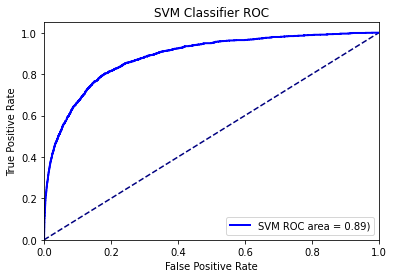

/home/cloudlet/anaconda3/envs/fsdet/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

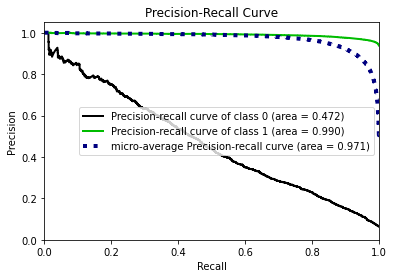

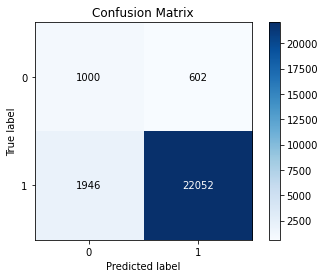

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import plot_precision_recall_curve
import scikitplot as skplt
print(predictedprobSVC.shape)
print(predictedprobSVC[:50,0])
print(predictedprobSVC[:50,1])
print(log_prob.shape)
print(log_prob[:50,0])
print(log_prob[:50,1])
y_score = clf.decision_function(X)
print(y_score.shape)
print(y_score[:50])
if not train:
    #GET ROC DATA
#     y_score = clf.decision_function(X)
    fpr, tpr, thresholds = roc_curve(y, log_prob[:,0], pos_label=0)
    roc_auc = auc(fpr, tpr)
    #GRAPH DATA
    plt.figure()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('SVM Classifier ROC')
    plt.plot(fpr, tpr, color='blue', lw=2, label='SVM ROC area = %0.2f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()
    
    plt.figure()
    skplt.metrics.plot_precision_recall_curve(y, predictedprobSVC)
    skplt.metrics.plot_confusion_matrix(y, y_hat)
    plt.show()

In [21]:
if not train:
    y_hat_should_pos = y_hat[y==0]
    TP = y_hat_should_pos[y_hat_should_pos==0].shape[0]
    FN = y_hat_should_pos[y_hat_should_pos!=0].shape[0]

    y_hat_should_neg = y_hat[y!=0]
    TN = y_hat_should_neg[y_hat_should_neg!=0].shape[0]
    FP = y_hat_should_neg[y_hat_should_neg==0].shape[0]

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    fp_rate = FP / (FP + TN)
    tp_rate = TP / (TP + FN)
    print('TP, FN, TN, FP = ', TP, FN, TN, FP)
    print('precision = ', precision)
    print('recall = ', recall)
    print('false positive rate = ', fp_rate)
    print('true positive rate = ', tp_rate)

TP, FN, TN, FP =  1000 602 22052 1946
precision =  0.3394433129667346
recall =  0.6242197253433208
false positive rate =  0.0810900908409034
true positive rate =  0.6242197253433208
